# 0. Installation and Usage

## 0.1 External Installations

In [1]:
%%bash
pip install -q gdown
pip install -q torch
pip install -q pytorch-lightning
pip install -q ultralytics
pip install -q ftfy regex tqdm
pip install -q git+https://github.com/openai/CLIP.git
pip install -q transformers==4.29
pip install -q sentencepiece==0.1.97

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 609.5/609.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.4 MB/s eta 0:00:00


## 0.2 Data

In [ ]:
%config NotebookApp.iopub_data_rate_limit=10000000

In [ ]:
# Download dataset from Google Drive
!gdown 1tkTUpbdkPqQ1JgHcVlsT0ikjcftF4P6x

Downloading...
From: https://drive.google.com/uc?id=1tkTUpbdkPqQ1JgHcVlsT0ikjcftF4P6x
To: /content/refcocog.tar.zip
100% 13.5G/13.5G [04:58<00:00, 45.1MB/s]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Move the file from the local pc to the drive

#!mv refcocog.tar.zip "/content/drive/My Drive/RefCOCOg/"

In [ ]:
%%bash


#unzip "/content/drive/My Drive/RefCOCOg/refcocog.tar.zip" -d "/content/drive/My Drive/RefCOCOg/"
#rm "/content/drive/My Drive/RefCOCOg/refcocog.tar.zip"

# Un-tar dataset and then remove tar file

tar -xvf "/content/drive/My Drive/RefCOCOg/refcocog.tar" -C "/content/drive/My Drive/RefCOCOg/"
rm "/content/drive/My Drive/RefCOCOg/refcocog.tar"

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 0.3 Imports

In [3]:
import os
import numpy as np
import pandas as pd
import pprint

import pickle
from typing import Any, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchmetrics


import pytorch_lightning as pl
from pytorch_lightning.utilities.types import STEP_OUTPUT

from transformers import T5Tokenizer, T5ForConditionalGeneration

from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import clip
from ultralytics import YOLO

# 1. Dataset

### 1.1 Dataset Class

In [4]:
from torch.utils.data import Dataset

import json

class RefCOCOg(Dataset):
    """
    Args:
        dataset: a list of dictionaries containing:
        {
            'file_name': # path of the image, images will be loaded on the fly
            'caption': # referring caption
            'ann_id': # annotation ID (one per caption), taken from 'file_name'
            'bbox': # coordinates (xmin, ymin, xmax, ymax) of the bounding box
        }
    """
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("/content/drive/My Drive/RefCOCOg/refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

### 1.2 Load Refs and Annotations

In [5]:
# Load refs and annotations
import pickle

with open("/content/drive/My Drive/RefCOCOg/refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

# 'annotations' will be a dict object mapping the 'annotation_id' to the 'bbox' to make search faster
with open("/content/drive/My Drive/RefCOCOg/refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

### 1.3 DataLoader

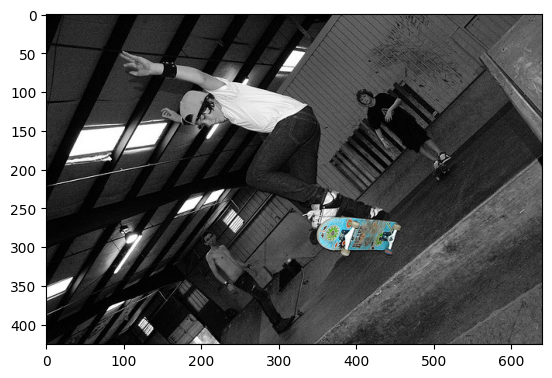

In [11]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw

def pad_image(image):
    """
    Performs bottom-right padding of the original image to 640x640 (max size of images in the dataset).
    Bottom-right padding prevents corruption of bounding boxes.

    ### Arguments
    image: a PIL.Image to transform
    """
    original_width, original_height = image.size
    padded_width, padded_height = 640, 640

    pad_width = padded_width - original_width
    pad_height = padded_height - original_height

    padded_image = Image.new(image.mode, (padded_width, padded_height), (0, 0, 0))
    padded_image.paste(image, (0, 0))

    return padded_image

def collate_fn(batch):
    images = []
    for sample in batch:
        image = Image.open(sample["file_name"]).convert("RGB")
        image = pad_image(image=image)
        images.append(transform(image))
    images = torch.stack(images, dim=0) #Concatenates a sequence of tensors along a new dimension.

    data = {}
    for key in batch[0].keys():
        if key != "file_name":
            data[key] = [sample[key] for sample in batch]

    print(data)
    print("--------------------------")

    return images, data

transform = transforms.Compose([
    transforms.Resize(244),
    transforms.CenterCrop(244),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

# create dataset and dataloader
dataset = RefCOCOg(refs, annotations, split="train")
plt.imshow(Image.open(dataset[2]["file_name"]))
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn)


### Usage:

# for d in dataloader:

#     img = np.array(d[0][0].cpu().numpy().transpose(1, 2, 0)*255, dtype=np.uint8)
#     bbox = d[1]["bbox"][0]
#     img = Image.fromarray(img)
#     draw = ImageDraw.Draw(img)
#     draw.rectangle(((bbox[0], bbox[1]), (bbox[2]+bbox[0], bbox[3]+bbox[1])), width=3)

#     plt.imshow(img)
#     plt.show()
#     break

Explanation of the code

1. **pad_image(image) Function**:
* This function takes an input PIL.Image and performs bottom-right padding to resize the image to a maximum size of 640x640. The purpose of this padding is to ensure that the bounding boxes in the dataset are not corrupted during transformations.
* It calculates the original width and height of the input image.
* Calculates the padding required for both width and height to reach the desired size (640x640).
* Creates a new PIL.Image with the specified padded dimensions and fills it with black color (0, 0, 0).
Overlays the original image onto the padded image at the top-left corner.
* Returns the padded image.
2. **collate_fn(batch) Function**:
* This function is used as a collate function for the DataLoader, which means it defines how to process a batch of samples before feeding them into the neural network.
* It takes a batch of samples, where each sample is a dictionary containing a "file_name" key (indicating the image file path) and other keys for different annotations or labels.
* For each sample in the batch:
  * It opens the image using the "file_name" key, converts it to the RGB mode, and then pads the image using the pad_image function.
  * The transformed image is then passed through the specified transform (in this case, a ToTensor transformation) to convert it into a PyTorch tensor.
* The transformed images are stacked along a new dimension (batch dimension) using torch.stack to form a batch of image tensors.
* The data dictionary is constructed to gather all other keys from the batch of samples except for the "file_name" key.
* The constructed data dictionary and the batch of transformed images are returned.
  
3. **transform Definition**:
* A PyTorch transformation composed of a single transformation step, transforms.ToTensor(), which converts the image to a PyTorch tensor.

4. **Dataset and DataLoader Setup**:
* A dataset named RefCOCOg is created using the provided refs, annotations, and split="train". This is likely a custom dataset class designed for a specific task.
* An example image from the dataset is opened using Image.open and displayed using plt.imshow.
* A DataLoader named dataloader is created using the dataset with a batch size of 1 and the previously defined collate_fn for processing batches.


In [12]:
iter_loader = iter(dataloader)
batch1 = next(iter_loader)
#pprint(batch1)

FileNotFoundError: ignored

### Utils

In [15]:
import torch
import clip
from PIL import Image, ImageDraw
import cv2
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [13]:
def load_image_plt(path):
    """ Load image with matplotlib"""
    return plt.imread(path)

def load_image_pil(path):
    """ Load image with PIL"""
    return Image.open(path)

def get_distance_box_iou_accuracy(box_pred, box_true, iou_threshold=0.5):
    """
    Given the target boxes and the prediction return the
    accuracy of the prediction. The accuracy is computed as
    the percentage of boxes that have an IoU > iou_threshold
    with the target box.

    Args:
    @params box_pred: tensor of shape (batch_size, n_boxes, 4)
    @params box_true: tensor of shape (batch_size, n_boxes, 4)
    @params iou_threshold: float

    Returns:
    @params accuracy: float

    """

    iou = torchvision.ops.box_iou(box_pred, box_true).diagonal()
    giou = torchvision.ops.generalized_box_iou(box_pred, box_true).diagonal()

    return (iou > iou_threshold).float().mean(), iou.mean(), giou.mean()

This function, **get_distance_box_iou_accuracy**, is designed to compute various accuracy metrics based on **Intersection over Union (IoU)** calculations for bounding boxes. It takes predicted bounding boxes and ground truth bounding boxes as inputs and returns three metrics: accuracy, IoU mean, and Generalized IoU mean. Here's what each part of the function does:




*   **box_pred**: This is a tensor containing predicted bounding boxes for a batch of images. It has a shape of **(batch_size, n_boxes, 4)**, where **batch_size** is the number of images in the batch, **n_boxes** is the number of boxes per image, and the last dimension represents the coordinates of each box **(x_min, y_min, x_max, y_max)**.
*   **box_true**: This is a tensor containing ground truth bounding boxes for the same batch of images. It has the same shape as **box_pred** and represents the correct bounding box coordinates for evaluation.
* **iou_threshold**: This is a floating-point value representing the IoU threshold used to determine whether a predicted box is considered accurate. If the IoU between a predicted box and a ground truth box is greater than this threshold, the predicted box is considered accurate.
* **iou**: The Intersection over Union (IoU) is calculated using **torchvision.ops.box_iou**, which computes the IoU between predicted and ground truth bounding boxes. The **.diagonal()** operation extracts the diagonal elements from the resulting IoU tensor. These diagonal elements represent the IoU between each predicted box and its corresponding ground truth box.
* **giou**: The Generalized Intersection over Union (GIoU) is calculated using **torchvision.ops.generalized_box_iou**, which computes the GIoU between predicted and ground truth bounding boxes. The **.diagonal()** operation extracts the diagonal elements from the resulting GIoU tensor.
* **accuracy**: This metric is calculated by comparing the IoU values to the **iou_threshold**. The number of predicted boxes with IoU values greater than the threshold is calculated using **(iou > iou_threshold)**. The **.float().mean()** operation computes the mean accuracy over all predicted boxes in the batch.
* **iou.mean()**: This returns the mean IoU over all predicted boxes in the batch.
* **giou.mean()**: This returns the mean GIoU over all predicted boxes in the batch.


### Baseline

In [14]:
class YoloClip():
    def __init__(self):

        self.yolo = torch.hub.load('ultralytics/yolov5', 'yolov5l6', pretrained=True)
        self.clip_model, self.clip_preprocess = clip.load("RN50", device=device)

    def infer_bboxes(self, image_path):
        results = self.yolo(image_path)
        bboxes = results.xyxy[0].cpu().numpy()
        return bboxes

    def encode_image(self, image):
        # Load and preprocess the image using CLIP preprocess function
        image = self.clip_preprocess(image).unsqueeze(0).to(self.device)

        # Encode the image using the CLIP model
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)

        return image_features

    def encode_text(self, text):
        # Encode the text using the CLIP model
        text = clip.tokenize(text).to(self.device)
        with torch.no_grad():
            text_features = self.clip_model.encode_text(text)

        return text_features

    def calculate_best_bbox(self, image_path, caption, device):
        text = clip.tokenize(caption).to(device)
        best_score = 0
        best_bbox = None

        for bbox in self.infer_bboxes(image_path):
            temp = cv2.imread(image_path)
            image = np.zeros((temp.shape[0], temp.shape[1], temp.shape[2]), dtype=np.uint8)
            image[int(bbox['ymin']):int(bbox['ymax']), int(bbox['xmin']):int(bbox['xmax'])] = temp[int(bbox['ymin']):int(bbox['ymax']), int(bbox['xmin']):int(bbox['xmax'])]
            image = Image.fromarray(image).to(device)

            with torch.no_grad():
                logits_per_image, logits_per_text = self.clip_model(image, text)
                matching_score = logits_per_text.cpu().numpy()[0]

            if matching_score > best_score:
                best_score = matching_score
                best_bbox = bbox

        return best_score, best_bbox

This code defines a Python class named **YoloClip** that combines the YOLO object detection model and the CLIP (Contrastive Language-Image Pretraining) model for image and text encoding. The purpose of this class is to perform various tasks such as object detection, image encoding, text encoding, and finding the best bounding box for a given image and caption pair.

* **\_\_init__** Method:
  * Initializes the class by loading the YOLOv5 model   (using Ultralytics' implementation) and the CLIP model.
  * The YOLOv5 model is loaded with the 'yolov5l6' variant and pretrained weights.
  * The CLIP model (ResNet-50 variant) and preprocess function are loaded.
* **infer_bboxes(image_path)** Method:
  * Uses the loaded YOLOv5 model to perform object detection on an image.
  * Returns the predicted bounding boxes as numpy arrays.
* **encode_image(image)** Method:
  * Preprocesses and encodes an image using the loaded CLIP model.
  * The image is preprocessed and encoded using the CLIP model's encode_image function.
* **encode_text(text)** Method:
  * Encodes a text input using the loaded CLIP model.
  * The text is tokenized and encoded using the CLIP model's encode_text function.
* **calculate_best_bbox(image_path, caption, device)** Method:
  * For a given image and caption, finds the best bounding box that matches the caption using CLIP.
  * It iterates over the bounding boxes predicted by YOLO for the image.
  * Extracts the region of interest (ROI) from the original image based on the bounding box.
  * Encodes both the image and the text caption using the CLIP model.
  * Calculates the matching score between the image and caption using the CLIP model.
  * Keeps track of the best matching score and the corresponding bounding box.
  * Returns the best matching score and the best bounding box.

The purpose of this class seems to be related to combining the strengths of YOLO for object detection and CLIP for image-text matching. It calculates the best bounding box based on the alignment between an image and a given text caption. This could be useful in scenarios where you want to find the region of an image that best matches a textual description.







In [16]:
# Constants and models

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# YOLO
model_yolo = YOLO("yolov8x.pt")

# CLIP
clip_model, clip_preprocess = clip.load("RN50", device=device)
clip_model.cuda().eval()

100%|██████████| 131M/131M [00:01<00:00, 76.1MB/s]
100%|███████████████████████████████████████| 244M/244M [00:04<00:00, 54.9MiB/s]


CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [18]:
checkpoint="unikei/t5-base-split-and-rephrase"
t5_tokenizer = T5Tokenizer.from_pretrained(checkpoint)
t5_model = T5ForConditionalGeneration.from_pretrained(checkpoint).to(device)

In [19]:
class LinearBoxWeightingBlock(nn.Module):
    def __init__(self, n_head=2, number_transformer_layers=2, dropout=0.1, emb_size=128, max_num_boxes=3, dim_emb_clip=512):
        super().__init__()

        self.linear_1 = nn.Linear(2, emb_size)

        self.layernorm_1 = nn.LayerNorm([max_num_boxes, dim_emb_clip, emb_size])
        self.gelu = nn.GELU()

        self.linear_2 = nn.Linear(emb_size*dim_emb_clip, emb_size)

        # In our architecture the transformer encoder uses layer norm first.
        # According to the results of the paper 'On Layer Normalization in
        # the Transformer Architecture' the convergence is faster if layer
        # norm is done first.
        # source: https://arxiv.org/pdf/2002.04745.pdf
        self.transformer_encoder = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=emb_size, nhead=n_head, norm_first=True, batch_first=True, activation=F.gelu), num_layers=number_transformer_layers
            )

        # This layer combines the output of the transformer encoder
        # with the initial concatenated embedding. The result of this layer is
        # a single vector for each box.
        self.linear_3 = nn.Linear(emb_size, emb_size)
        self.layernorm_2 = nn.LayerNorm([max_num_boxes, emb_size])

        self.linear_4 = nn.Linear(emb_size, 1)

        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        x = x.permute(0, 3, 2, 1)                   # permute
        x = self.linear_1(x)                        # linear transformation
        x = self.gelu(x)                            # non-linearity
        x = self.layernorm_1(x)                     # norm
        x = x.flatten(start_dim=2, end_dim=-1)      # flatten
        x = self.linear_2(x)                        # linear transformation
        x = self.gelu(x)                            # non-linearity
        x = self.transformer_encoder(x)             # transformer encoder

        if self.training:
          x = self.linear_3(self.dropout(x))        # linear transformation
        else:
          x = self.linear_3(x)                      # linear transformation
        x = self.gelu(x)                            # non-linearity
        x = self.layernorm_2(x)                     # norm
        x = self.linear_4(x)                        # linear transformation

        return x

This code defines a PyTorch module class called **LinearBoxWeightingBlock**. This module appears to be part of a larger neural network architecture for some kind of machine learning task, likely involving computer vision. The purpose of this class is to process input data related to boxes (bounding boxes or regions of interest) and produce an output based on a sequence of neural network operations. Let's break down the components of this class:
* **Initialization (\_\_init__ method)**:
  * The constructor takes several parameters:
  * **n_head**: The number of attention heads in the Transformer encoder layers.
  * **number_transformer_layers**: The number of Transformer encoder layers.
  * **dropout**: The dropout rate used throughout the module.
  * **emb_size**: The embedding size for intermediate representations.
  * **max_num_boxes**: The maximum number of boxes in the input sequence.
  * **dim_emb_clip**: The embedding dimension of the CLIP model (which seems to be used as an input).
* **Module Components**:
  * **linear_1**: A linear layer that performs an initial linear transformation on the input data.
  * **layernorm_1**: A layer normalization operation applied to the output of **linear_1**.
  * **gelu**: GELU activation function.
  * **linear_2**: Another linear layer applied after the GELU activation.
  * **transformer_encoder**: A stack of Transformer encoder layers applied to the output of **linear_2**.
  * **linear_3**: A linear layer that operates on the output of the Transformer encoder. Its application is controlled by dropout during training.
  * **layernorm_2**: Another layer normalization applied to the output of **linear_3**.
  * **linear_4**: A final linear layer that produces a single value for each box.
  * **dropout**: A dropout layer applied to the output of **linear_3** during training.
* **Forward Pass (forward method)**:
  * The forward method processes the input tensor **x** through the different layers in the module in a specific sequence.
  * The input tensor is reshaped and passed through the series of linear transformations, activations, normalization layers, and the Transformer encoder.
  * The final output is produced by applying linear transformations, activations, and normalization, resulting in a single scalar value per box.

In [20]:
class CLIPscoreBlock(nn.Module):
    '''
    This block computes the batched clip score for each box.
    The input is the text embedding and the box embedding.
    The output is a tensor of shape (batch_size, n_boxes, 1)
    where each element is the score of the box.

    Args:
        @params text_emb: tensor of shape (batch_size, 512)
        @params box_emb: tensor of shape (batch_size, n_boxes, 512)

    Returns:
        @params returns x: tensor of shape (batch_size, n_boxes, 1)

    x:  [tex_0 @ box_1.T, tex_0 @ box_2.T, ..., tex_0 @ box_j]
        [tex_1 @ box_1.T, tex_1 @ box_2.T, ..., tex_1 @ box_j]
        [tex_2 @ box_1.T, tex_2 @ box_2.T, ..., tex_2 @ box_j]
                                ...
                                ...
        [tex_i @ box_1.T, tex_i @ box_2.T, ..., tex_i @ box_j]

    Normalizing over the rows and summing over the columns
    to get the overall score for each box.

    x summarize the matching in between the sentence and the boxes
    x: [sum(tex_[:] @ box_1.T), sum(tex_[:] @ box_2.T), ..., sum(tex_[:] @ box_j)]
    '''
    def __init__(self, n_box=48):
        super().__init__()
        self.n_box = n_box


    def forward(self, box_encoding, text_emb):

        x = torch.bmm(text_emb.squeeze(-1), box_encoding) # (B, D) @ (B, D)
        x = x.sum(dim=-2)

        return x

This code defines a PyTorch module class named **CLIPscoreBlock**. This module computes a batched CLIP (Contrastive Language-Image Pretraining) score for each box in a set of bounding boxes, given text and box embeddings as input. The computed score indicates how well each box matches the provided text embedding.

Here's a breakdown of the components and functionality of this class:
* **Initialization (\_\_init__ method)**:
  * The constructor takes one parameter:
      * **n_box**: The number of boxes.
* **Forward Pass (forward method)**:
  * The forward method computes the CLIP score for each box based on text and box embeddings.
  * It takes two arguments:
      * **box_encoding**: A tensor of shape (**batch_size, n_boxes, 512)**, representing box embeddings.
      * **text_emb**: A tensor of shape **(batch_size, 512)**, representing the text embedding.
  * The method computes the CLIP score by performing a batch matrix multiplication **(torch.bmm)** between the text embedding (after squeezing the last dimension) and the box embeddings. This operation calculates the cosine similarity between each box embedding and the text embedding.
  * The result is a tensor **x** of shape **(batch_size, n_boxes)**, where each element represents the score of a box based on its similarity to the text embedding.
  * The scores are then summed along the second dimension (representing boxes) using **x.sum(dim=-2)** to get an overall score for each box.
* **Output**:
  * The output tensor **x** has a shape **(batch_size, n_boxes)**, where each element in the tensor represents the computed score for a specific box with respect to the provided text embedding.
* **Explanation of Calculation**:
  * The computation is akin to taking the dot product between the text embedding and each box embedding, which measures their similarity.
  * The final output represents how well each box aligns with the given text embedding.

In [21]:
class FinetunedRephrasing(pl.LightningModule):
    def __init__(self, out_dim_box=512, latent_dim=240, hidden_dim_regressor=256):
        super().__init__()

        self.linWeighting = LinearBoxWeightingBlock()
        self.clipScoreBlock = CLIPscoreBlock()

        self.resizer = nn.Linear(1, 4)

        self.save_hyperparameters()

        # https://arxiv.org/pdf/2108.12627
        self.HUBER = nn.SmoothL1Loss()
        self.accuracy = get_distance_box_iou_accuracy

        # self.MSE = nn.MSELoss()
        # self.MAE = nn.L1Loss()
        # self.generalized_box_iou_loss = torchvision.ops.generalized_box_iou_loss
        # https://arxiv.org/abs/1911.08287
        # self.distance_box_iou_loss = torchvision.ops.distance_box_iou_loss
        # https://arxiv.org/abs/1902.09630
        # self.complete_box_iou_loss = torchvision.ops.complete_box_iou_loss

    def forward(self, x, box, text_emb):

        x_1 = self.clipScoreBlock(x[:,0,:,:], text_emb)

        # sort the boxes according to the similarity score
        _, idx = torch.sort(x_1, dim=1, descending=True)
        x = x.gather(3, idx.unsqueeze(-2).unsqueeze(-2).repeat(1, 2, 512, 1))[:,:,:,:3]
        x_1 = x_1.gather(1, idx)[:,:3].unsqueeze(-1)
        box = box.gather(1, idx.unsqueeze(-1).repeat(1, 1, 4))[:,:3]

        x = self.linWeighting(x)

        # shift the scores
        x = x_1 + x

        # box: (batch_size, 48, 1), (batch_size, 48, 4) -> (batch_size, 48, 5)
        x = torch.cat([x, box], dim=-1)

        # sort again the boxes according to the similarity score
        _, idx = torch.sort(x[:, :, 0], dim=1, descending=True)
        x = x.gather(1, idx.unsqueeze(-1).repeat(1, 1, 5))[:, 0, :]

        resize = self.resizer(x[:,0].unsqueeze(-1))

        return resize + x[:,1:]

    def training_step(self, batch, batch_idx):

        cat_emb_text, box, t_emb, target = batch

        pred = self(cat_emb_text, box, t_emb)

        huber_loss = self.HUBER(pred, target)

        accuracy, iou_mean, giou_mean = self.accuracy(pred, target)

        self.log('train_accuracy', accuracy, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_huber_loss', huber_loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_iou_mean', iou_mean, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_giou_mean', giou_mean, on_step = True, on_epoch = True, prog_bar = True, logger = True)

        return huber_loss * (1.4 - iou_mean)

    def validation_step(self, batch, batch_idx):
        cat_emb_text, box, t_emb, target = batch
        # print(cat_emb_text.shape, box.shape, y.shape)
        pred = self(cat_emb_text, box, t_emb)

        huber_loss = self.HUBER(pred, target)

        accuracy, iou_mean, giou_mean = self.accuracy(pred, target)

        self.log('train_accuracy', accuracy, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_huber_loss', huber_loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_iou_mean', iou_mean, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_giou_mean', giou_mean, on_step = True, on_epoch = True, prog_bar = True, logger = True)

        return huber_loss * (1.4 - iou_mean)


    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.5)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20)
        return [optimizer], [scheduler]

This code defines a PyTorch Lightning module named **FinetunedRephrasing** for a machine learning task. The module is designed to perform a rephrasing task using a combination of CLIP (Contrastive Language-Image Pretraining) and YOLO-like object detection mechanisms. It fine-tunes a model for the task and includes training and validation steps. Here's an explanation of the various components and methods:
* **Initialization (\_\_init__ method)**:
  * The constructor takes a few hyperparameters related to the model architecture and training.
  * The model includes instances of **LinearBoxWeightingBlock** and **CLIPscoreBlock** as well as a linear resizer.
  * The **HUBER** loss and an accuracy metric function are defined for training.
* **Forward Pass (forward method)**:
  * Given text embeddings, box embeddings, and image data, this method performs various operations to rephrase the input image.
  * The method first computes CLIP scores using the **CLIPscoreBlock**.
  * It then sorts and selects the top-scoring boxes.
  * The **LinearBoxWeightingBlock** is used to compute weights for the selected boxes.
  * The scores are shifted and combined with the original scores.
  * The box embeddings are concatenated with scores and then sorted again based on scores.
  * Finally, a linear resizer is applied, and the rephrased output is returned.
* **Training Step (training_step method)**:
  * Computes predictions, Huber loss, and accuracy metrics using forward pass.
  * Logs the metrics for tracking progress.
* **Validation Step (validation_step method)**:
  * Similar to the training step but used during validation.
* **Configure Optimizers (configure_optimizers method)**:
  * Configures an AdamW optimizer with a learning rate of **0.5**.
  * Uses a **CosineAnnealingWarmRestarts** learning rate scheduler.

In [22]:
class SentenceRephrase(nn.Module):
    def __init__(self, model, tokenizer, device, max_sents = 24):
        super(SentenceRephrase, self).__init__()
        # self.model = T5ForConditionalGeneration.from_pretrained(checkpoint).to(device)
        # self.tokenizer = T5Tokenizer.from_pretrained(checkpoint)

        self.model = model.to(device)
        self.model.eval()
        self.tokenizer = tokenizer
        self.device = device
        self.beam_size = max_sents # represent a good trade-off between quality and diversity


    def sentence_cut(sentence, t = 140):
        return sentence[:t] if len(sentence) > t  else sentence

    def forward(self, captions):

        print('Rephrasing sentences...')
        print('Original captions: ', captions)

        # move to device and tokenize the captions
        tokenized = self.tokenizer(captions,
                                padding="max_length",
                                truncation=True,
                                max_length=140,
                                return_tensors='pt')

        # generate the rephrased sentences
        simple_tokenized = self.model.generate(tokenized['input_ids'].to(device),
                                attention_mask = tokenized['attention_mask'].to(device),
                                max_length=140,
                                num_beams=self.beam_size,
                                num_return_sequences=self.beam_size-len(captions)
                            )

        # decode the generated sentences
        rephrased = self.tokenizer.batch_decode(simple_tokenized, skip_special_tokens=True)

        print('Rephrased captions: ', rephrased)

        # add to the original captions
        captions = captions + rephrased
        # cut sentences longer than 140 tokens
        t = 140
        captions = [sentence[:t] if len(sentence) > t else sentence for sentence in captions]

        return captions

This code defines a PyTorch module class called **SentenceRephrase** for generating rephrased sentences using a pre-trained language model (such as T5) for conditional text generation. The module takes in original captions, rephrases them using the language model, and then returns the original captions along with the rephrased sentences.

Here's a breakdown of the different components and functionalities of this class:
* **Initialization (\_\_init__ method)**:
  * The constructor takes several parameters:
      * **model**: A pre-trained language model for text generation.
      * **tokenizer**: A tokenizer corresponding to the language model.
      * **device**: The device (e.g., "cuda" for GPU or "cpu") on which to run the model.
      * **max_sents**: The maximum number of sentences to generate using beam search.
**Sentence Cutting Function (sentence_cut method)**:
  * A static method that truncates a sentence to a specified length **t** if its length exceeds **t**.
* **Forward Pass (forward method)**:
  * Given a list of original captions, this method performs the following steps:
      * Tokenizes the captions using the provided tokenizer.
      * Generates rephrased sentences using the language model through beam search.
      * Decodes the generated token sequences to obtain rephrased sentences.
      * Concatenates the rephrased sentences with the original captions.
      * Truncates the sentences longer than 140 tokens.
      Returns the rephrased captions.
* **Usage of the Module**:
  * The **SentenceRephrase** module is intended to be used for generating alternative versions (rephrases) of input captions using a language model capable of conditional text generation.
* **Output**:
  * The output of the **forward** method is a list of captions, including both the original captions and the generated rephrased captions.

In [23]:
class YOLOv8DetectorModule(nn.Module):
    def __init__(self, model, preprocess, device):
        super(YOLOv8DetectorModule, self).__init__()
        self.model_yolo = model
        self.preprocess = preprocess
        self.device = device

        # image normalization
        # mean-std input image normalization
        self.transform = transforms.Compose([
                                transforms.Resize(size=224, interpolation='bicubic', max_size=None, antialias=None),
                                transforms.CenterCrop(size=(224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
                            ])

    def get_crops(self, yolov8_df, image):
        """ Get crops of the image from yolov8_df

        Args:
            yolov8_df (pd.DataFrame): DataFrame with yolov5 predictions
            image (np.array): image as np.array

        Returns:
            list: crops

        """
        crops = []
        image = image

        for box in yolov8_df.values:
            x_min, y_min, x_max, y_max, confidence = box[:5]

            if confidence > 0.6:
                crop = image[int(y_min):int(y_max), int(x_min):int(x_max)]
                crop = Image.fromarray((crop * 255).astype(np.uint8))
                crops.append(crop)

        # add the entire image
        crops.append(Image.fromarray(image))

        return crops

    def get_crops_preprocessed_for_clip(self, yolov8_df, image):
        """ Get crops from yolov8_df and preprocess them for CLIP

        Args:
            yolov8_df (pd.DataFrame): DataFrame with yolov5 predictions
            image (np.array): image as np.array

        Returns:
            torch.tensor: preprocessed crops

        """
        crops = []
        boxes = []
        image = image

        for box in yolov8_df.values:
            x_min, y_min, x_max, y_max, confidence = box[:5]
            if confidence > 0.6:
                crop = image[int(y_min):int(y_max), int(x_min):int(x_max)]
                crop = Image.fromarray((crop * 255).astype(np.uint8))#.convert('RGB')
                crop = self.preprocess(crop)
                crops.append(crop)
                boxes.append(torch.tensor([x_min, y_min, x_max, y_max]).type(torch.float32).unsqueeze(0))

        return torch.stack(crops).to(self.device), torch.cat(boxes).to(self.device)

    def plot_image_yolov8(self, results, image):
        """Plot the images with the boxes"""
        for i in results.xyxy[0]:
            if i[4] > 0.6: # if confidence is greater than 0.5
                # Create figure and axes
                _, ax = plt.subplots()

                boxes = i[:4]

                # Display the image
                ax.imshow(image)

                # Create a Rectangle patch
                x_min, y_min, width, height = boxes.tolist()
                ax.add_patch(Rectangle((x_min, y_min), width-x_min, height-y_min, linewidth=1, edgecolor='r', facecolor='none'))

                ax.axes.xaxis.set_visible(False)
                ax.axes.yaxis.set_visible(False)

                plt.show()

    def plot_image_bbox(self, boxes, images, captions):
        """Plot the images with the boxes"""
        for bbox, image, c in zip(boxes.tolist(), images, captions):
              # Create figure and axes
              _, ax = plt.subplots()

              # Display the image
              ax.imshow(image)

              # Create a Rectangle patch
              x_min, y_min, width, height = bbox
              ax.add_patch(Rectangle((x_min, y_min), width-x_min, height-y_min, linewidth=1, edgecolor='r', facecolor='none'))

              ax.axes.xaxis.set_visible(False)
              ax.axes.yaxis.set_visible(False)

              plt.title(c[0])

              plt.show()

    def forward(self, images_path):

        print('Detecting objects in the images...')
        # get yolov8 predictions
        results = self.model_yolo([load_image_pil(i) for i in images_path])

        print('Boxes detected!')

        # store the predictions into a dataframe
        results = [pd.DataFrame(result.boxes.data.tolist(), columns=['x_min', 'y_min', 'x_max', 'y_max', 'confidence', 'class']) for result in results]

        print('Preprocessing crops with CLIP...')

        # preprocess the images for CLIP
        cropPreprocessed_boxes = [
            self.get_crops_preprocessed_for_clip(yolov8_df, image)
                    for yolov8_df, image in zip(results, [load_image_plt(i) for i in images_path])
                ]

        imgs_preproc = [i[0] for i in cropPreprocessed_boxes]
        yolo_boxes = [i[1] for i in cropPreprocessed_boxes]

        if len(yolo_boxes) == 1:
            yolo_boxes = yolo_boxes[0].unsqueeze(0).to(torch.float32)
            imgs_preproc = imgs_preproc[0].unsqueeze(0).to(torch.float32)
        else:
            yolo_boxes = torch.cat(yolo_boxes).to(torch.float32)
            imgs_preproc = torch.cat(imgs_preproc).to(torch.float32)

        return imgs_preproc, yolo_boxes

This code defines a PyTorch module class called **YOLOv8DetectorModule**, which is designed to detect objects in images using the YOLOv8 model and preprocess the detected object regions for use with CLIP (Contrastive Language-Image Pretraining).

Here's an explanation of the various components and methods within the class:
* **Initialization (\_\_init__ method)**:
  * The constructor takes a pre-trained YOLOv8 model, a preprocessing function, and the device to run the model on.
  * It also defines a transformation pipeline to normalize images using mean and standard deviation.
* **get_crops method**:
  * Takes YOLOv8 predictions (in a **DataFrame** format) and an image as input.
  * Extracts and returns image crops based on the bounding box coordinates from the predictions.
  * Also appends the entire image as a crop.
* **get_crops_preprocessed_for_clip method**:
  * Similar to **get_crops**, but preprocesses the extracted crops using the provided preprocessing function.
  * Returns the preprocessed crops along with the corresponding box coordinates.
* **plot_image_yolov8 method**:
  * Takes YOLOv8 predictions (in the format of the **results** object), and an image as input.
  * Plots the image and overlays bounding boxes corresponding to the detected objects with confidence greater than 0.5.
* **plot_image_bbox method**:
  * Takes bounding box coordinates, images, and captions as input.
  * Plots the image with the bounding boxes overlaid on top and the associated captions as titles.
* **forward method**:
  * Takes a list of image paths as input.
  * Runs the YOLOv8 model on the provided images to obtain object detection results.
  * Converts the results into **DataFrames** and preprocesses the detected object regions for CLIP.
  * Returns the preprocessed image crops and corresponding bounding box coordinates.

In [24]:
class RephrasingDetectorModel(pl.LightningModule):
    def __init__(self, clip_model, clip_tokenizer, yolo_module, rephraser_module, finetuned_model, device):
        super().__init__()

        self.clip_model = clip_model
        self.clip_tokenizer = clip_tokenizer
        self.yolo_module = yolo_module
        self.rephraser_module = rephraser_module
        self.finetuned_model = finetuned_model


    def get_image_features(self, images):
        """Get the clip image features"""

        print('Encoding images...')

        with torch.no_grad():
            image_features = self.clip_model.encode_image(images)
        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        return image_features

    def get_text_features(self, text):
        """Get the clip text features"""

        print('Encoding text...')

        with torch.no_grad():
            text_features = self.clip_model.encode_text(self.clip_tokenizer([t for t in text]).to(device))
        # Normalize features
        text_features /= text_features.norm(dim=-1, keepdim=True)
        return text_features

    def get_score_similarities(self, image_features, text_features):
        """Get the clip similarities"""
        # Calculate similarity
        similarities = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        return similarities

    def detector_inference(self, images):
        # get preprocessed crops of the objects
        # in the original images
        x = [self.yolo_module(image) for image in images]
        max_crop_shape = max([crop[1].shape[1] for crop in x])
        imgs_crops, yolo_boxes = [crop[0] for crop in x], torch.cat([torch.nn.functional.pad(crop[1], (0, 0, max_crop_shape-crop[1].shape[1], 0)) for crop in x])
        return imgs_crops, yolo_boxes

    def box_norm_rescale(self, box_target):
        """ Rescale the box_target
        Args:
            box_target: (number of samples, 1, 4)

        Returns:
            box_target: (number of samples, 1, 4)

        """
        # convert the box_pred to x1, y1, x2, y2
        box_target[:, 0, 2] = box_target[:, 0, 0] + box_target[:, 0, 2]
        box_target[:, 0, 3] = box_target[:, 0, 1] + box_target[:, 0, 3]

        return box_target


    def forward(self, x, captions):
        """Forward pass"""

        # get the preprocessed crops of the objects in
        # the original images
        imgs_crops, yolo_boxes = self.detector_inference(x)

        # rephrase the captions
        if len(captions) == 1:
            captions = [self.rephraser_module.forward(captions)]
        else:
            captions = [self.rephraser_module.forward(caption) for caption in captions]

        print('Extracting features with CLIP...')

        # extract the clip text features
        caption_features = torch.stack(
            [self.get_text_features(caption) for caption in captions]
          ).unsqueeze(-1).to(torch.float32)

        # extract the clip image features
        images_features = [self.get_image_features(img_crops.squeeze(0)).unsqueeze(0) for img_crops in imgs_crops]
        max_shape = max([crops.shape[1] for crops in images_features])
        images_features = torch.cat([torch.nn.functional.pad(crops, (0, 0, max_shape-crops.shape[1], 0)) for crops in images_features]).permute(0, 2, 1).unsqueeze(1).to(torch.float32)


        print('Prepare the data...')

        # concatenate the image and text features
        cat_img_txt_features = torch.cat(
            [images_features, caption_features.squeeze(-1)[:,0,:].unsqueeze(1).unsqueeze(-1).repeat(1, 1, 1, images_features.shape[3])], dim=1
            ).to(torch.float32)

        # check that the number of boxes are > 3
        if cat_img_txt_features.shape[3] < 3:
            # pad the tensor with zeros
            cat_img_txt_features = torch.cat(
                [cat_img_txt_features, torch.zeros(cat_img_txt_features.shape[0], cat_img_txt_features.shape[1], cat_img_txt_features.shape[2], 3 - cat_img_txt_features.shape[3]).to(device)], dim=3
              )

        yolo_boxes = self.box_norm_rescale(yolo_boxes)

        pred = self.finetuned_model.forward(cat_img_txt_features, yolo_boxes, caption_features)

        return pred

This code defines a PyTorch Lightning module class called **RephrasingDetectorModel**. This class is responsible for integrating multiple components including CLIP, YOLO, rephraser, and a finetuned model to perform a combined task involving image detection, rephrasing, and prediction.

Here's an explanation of the different components and methods within the class:
* **Initialization (\_\_init__ method)**:
  * The constructor takes multiple pre-trained models, tokenizers, modules, and device as input arguments.
  * The models include **clip_model**, **yolo_module**, **rephraser_module**, and **finetuned_model**.
* **get_image_features** method:
  * Takes images as input and encodes them using the clip_model to obtain image features.
  * The encoded features are normalized.
* **get_text_features** method:
  * Takes a list of texts as input and encodes them using the **clip_model** and the provided **clip_tokenizer** to obtain text features.
  * The encoded features are normalized.
* **get_score_similarities** method:
  * Takes image features and text features as input.
  * Computes the similarity scores between the image features and text features using dot product and softmax.
* **detector_inference** method:
  * Takes images as input and performs object detection using the **yolo_module**.
  * Returns preprocessed image crops and corresponding YOLO bounding box coordinates.
* **box_norm_rescale** method:
  * Takes the YOLO box predictions and rescales them from relative coordinates to absolute coordinates.
* **forward** method:
  * Takes images (**x**) and captions as input.
  * Calls **detector_inference** to obtain preprocessed crops and YOLO box predictions.
  * Rephrases the captions using the **rephraser_module**.
  * Extracts text features and image features using **get_text_features** and **get_image_features methods**.
  * Concatenates text and image features to prepare the data.
  * If the number of boxes is less than 3, pads the tensor with zeros.
  * Passes the concatenated features and YOLO box predictions to the **finetuned_model**.
  * Returns the predictions.

The RephrasingDetectorModel class serves as a high-level module that integrates several sub-modules to perform complex tasks involving image detection, rephrasing, and prediction. This type of integrated model can be useful for tasks that require multiple intermediate steps and components to achieve a final result.

In [25]:
sentence_rephrase_module = SentenceRephrase(t5_model, t5_tokenizer, device).to(device)
yolo_detector_module = YOLOv8DetectorModule(model_yolo, clip_preprocess, device).to(device)

fine_tuned_model = FinetunedRephrasing().to(device)
#fine_tuned_model = fine_tuned_model.load_from_checkpoint('./c2lip-box_simpified_128-epoch=70-val_loss=0.00-other_metric=0.00.ckpt')

model_finetuned = RephrasingDetectorModel(clip_model, clip.tokenize, yolo_detector_module, sentence_rephrase_module, fine_tuned_model, device)

# count the number of parameters
print(f"Number of parameters: {sum(p.numel() for p in model_finetuned.parameters() if p.requires_grad)/1000000} M")

dataset = RefCOCOg(refs, annotations, split="test")
# dataset = RefCOCOg(refs, annotations, split="val")

interval = np.arange(30, 3000, 300)

path_imgs = [[dataset[i]['file_name']] for i in interval]
captions = [[dataset[i]['caption']] for i in interval]


bboxes_pred = model_finetuned(path_imgs, captions).detach().cpu()

Number of parameters: 334.89649 M
Detecting objects in the images...


FileNotFoundError: ignored

* **SentenceRephrase** and **YOLOv8DetectorModule** Initialization:
  * **SentenceRephrase** and **YOLOv8DetectorModule** are initialized with the appropriate models, tokenizers, preprocess functions, and the target device. These modules are responsible for rephrasing captions and performing object detection using YOLOv8.
* **FinetunedRephrasing** Initialization:
  * The **FinetunedRephrasing** model is initialized and moved to the specified device. This model is responsible for combining object detection, caption rephrasing, and other components.
* **RephrasingDetectorModel** Initialization:
  * **RephrasingDetectorModel** is initialized by combining the initialized modules (**clip_model**, clip.**tokenize**, **yolo_detector_module**, **sentence_rephrase_module**, **fine_tuned_model**) as components. This model encapsulates the entire pipeline for rephrasing and detecting objects.
* **Counting Parameters**:
  * The code calculates and prints the number of trainable parameters in the **RephrasingDetectorModel**.
* **Dataset and Interval Setup**:
  * The **RefCOCOg** dataset is loaded using the provided refs and annotations. The dataset is loaded for testing (**split="test"**).
  * An interval of indices (**interval**) is defined to select specific images and captions for testing.
* **Inference**:
  * The file names and captions corresponding to the defined interval are extracted from the dataset.
  * The **model_finetuned** is used to perform inference on the provided images and captions.
  * The resulting predicted bounding boxes (**bboxes_pred**) are stored as tensors on the CPU.

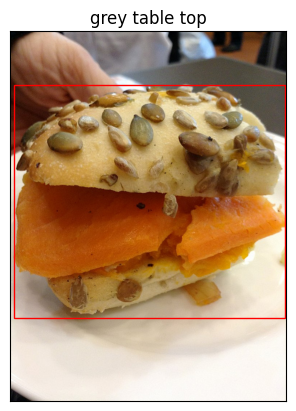

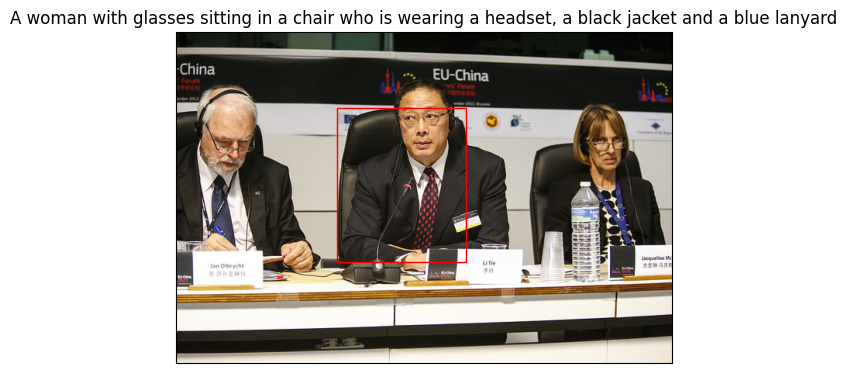

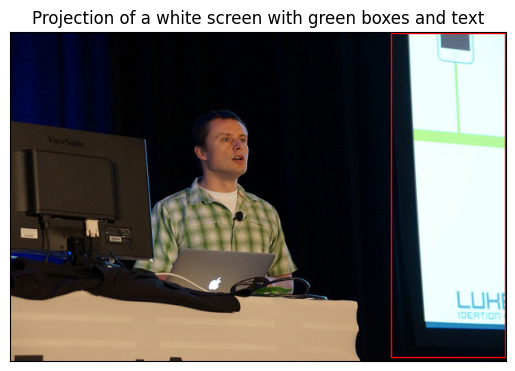

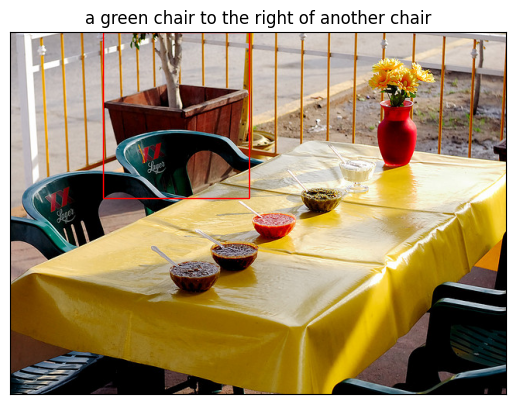

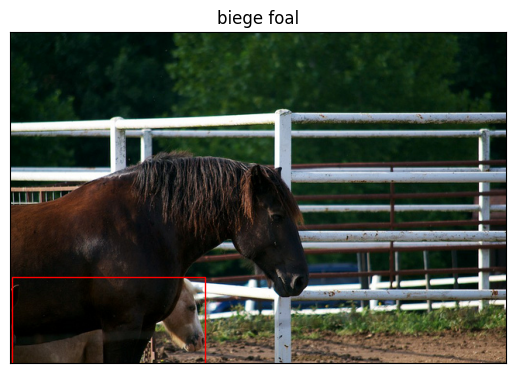

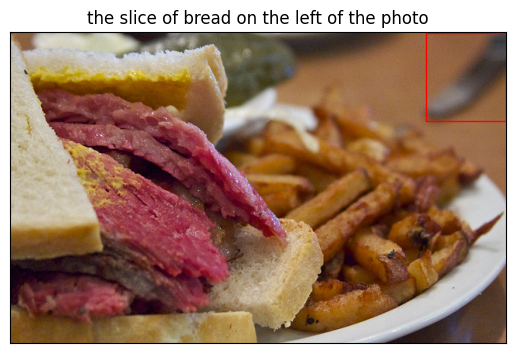

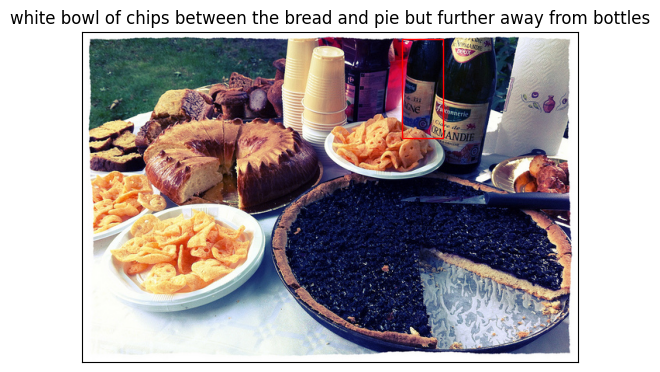

In [ ]:
images = [load_image_pil(i[0]) for i in path_imgs]
yolo_detector_module.plot_image_bbox(bboxes_pred, images, captions)